In [35]:
import pandas as pd
import sklearn as sk
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from liver_functions import import_data
from liver_functions import one_hot_encode
from liver_functions import split_data
from joblib import dump, load

def build_pipeline(classifier, isScaled):
    if isScaled:
        pipe = Pipeline(steps=[("imputer", SimpleImputer()),
                               ("scale", StandardScaler()),
                               ("clf", classifier)])
    else:
        pipe = Pipeline(steps=[("imputer", SimpleImputer()),
                               ("clf", classifier)])
        
    return pipe
    
def run_gridsearch(pipe, param_grid, num_folds, metric, X_train, y_train):
    search = GridSearchCV(pipe, param_grid, cv=num_folds, scoring=metric)
    search.fit(X_train, y_train)
    dump(search.best_estimator_, "test_model.pkl")
    
    return search.best_params_, search.best_score_, search.best_estimator_ 

    
# Example
df = import_data("Indian Liver Patient Dataset (ILPD).csv")
df = one_hot_encode(df, "gender")
display(df)
X_train, y_train, X_test, y_test = split_data(df, 0.2, "is_patient")
pipe = build_pipeline(KNeighborsClassifier(), True)
param_grid = dict(clf__n_neighbors=list(range(1,10)))
params, score, model = run_gridsearch(pipe, param_grid, 10, "f1", X_train, y_train)

,Female,Male,age,tot_bilirubin,direct_bilirubin,tot_proteins,albumin,ag_ratio,sgpt,sgot,alkphos,is_patient
0,1,0,65,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,0,1,62,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,0,1,62,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,0,1,58,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,0,1,72,3.9,2.0,195,27,59,7.3,2.4,0.40,1
...,...,...,...,...,...,...,...,...,...,...,...,...
578,0,1,60,0.5,0.1,500,20,34,5.9,1.6,0.37,2
579,0,1,40,0.6,0.1,98,35,31,6.0,3.2,1.10,1
580,0,1,52,0.8,0.2,245,48,49,6.4,3.2,1.00,1
581,0,1,31,1.3,0.5,184,29,32,6.8,3.4,1.00,1


/Users/mchifala/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [653]:
sorted(sk.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

./Users/mchifala/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:268: PendingDeprecationWarning: 
The label function will be deprecated in a future version. Use Tick.label1 instead.
  fontsize = tick.label.get_size()
...
----------------------------------------------------------------------
Ran 4 tests in 0.152s

OK


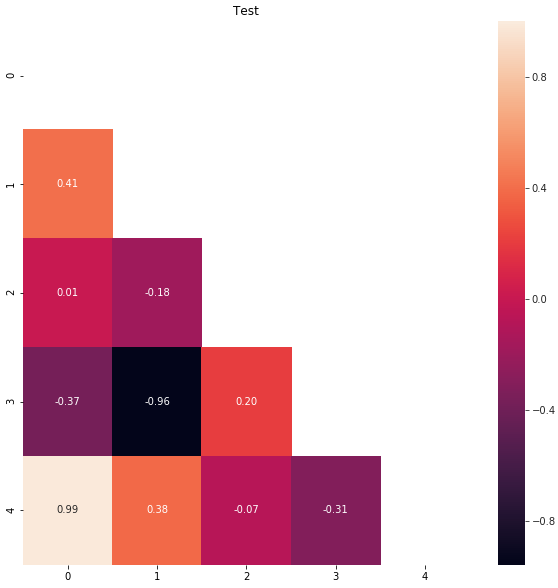

In [2]:
import unittest
import numpy as np
import pandas as pd
import string
import random
import os

from liver_functions import import_data
from liver_functions import one_hot_encode
from liver_functions import split_data
from liver_functions import make_correlation_heatmap

class TestFunctions(unittest.TestCase):
    
    def make_char_file(self):
        n = 5
        data = np.random.choice(list(string.ascii_lowercase),
                                     size=(n,n), replace = False)
        np.savetxt("test_data.csv", data, fmt= "%c", delimiter=",")
        return data
    
    def make_num_df(self):
        n = 5
        data = np.random.choice(100, size=(n,n), replace = False)
        return pd.DataFrame(data)
    
    def make_gender_df(self):
        n = 50
        gender = [random.choice(["Male", "Female"]) for i in range(n)]
        df = pd.DataFrame(gender, columns=["gender"])
        return df
    
    def test_heatmap(self):
        df = self.make_num_df()
        make_correlation_heatmap(df, "Test", "test.png")
        self.assertEqual(True, os.path.exists("test.png"))
         
    def test_one_hot(self):
        df = self.make_gender_df()
        df_enc = df.copy()
        df_enc["Male"] = df_enc["gender"].apply(lambda x: 1 if x == "Male" else 0)
        df_enc["Female"] = df_enc["gender"].apply(lambda x: 1 if x == "Female" else 0)
        df_enc.drop(columns = ["gender"],  inplace = True)
        pd.testing.assert_frame_equal(df_enc, one_hot_encode(df, "gender"),
                                      check_like = True, 
                                      check_dtype = False)

    def test_data_import(self):
        data = self.make_char_file()
        df = pd.DataFrame(data, columns= [x for x in data[0,:]])
        df = df.reindex(df.index.drop(0)).reset_index(drop=True)
        df_import = import_data("test_data.csv")
        pd.testing.assert_frame_equal(df, df_import, check_less_precise = 0) 

    
    def test_split(self):
        frac = 0.2
        data = self.make_char_file()
        n = len(data)
        df = pd.DataFrame(data, columns = [str(x) for x in range(n)])
        X_train, y_train, X_test, y_test = split_data(df, frac, str(n-1))
        
        self.assertEqual(np.shape(X_train), (round((1-frac)*n), n-1))
        self.assertEqual(np.shape(X_test), (round((frac)*n), n-1))
        self.assertEqual(np.shape(y_train), (round((1-frac)*n), ))
        self.assertEqual(np.shape(y_test), (round((frac)*n), ))
                                   
if __name__ == '__main__':        
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

1
2


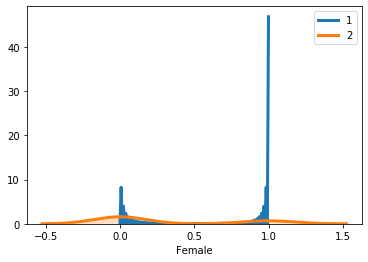

1
2


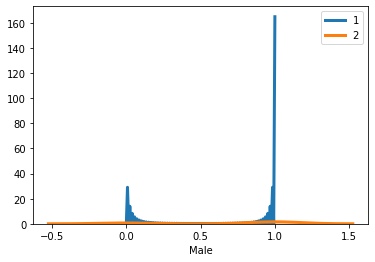

1
2


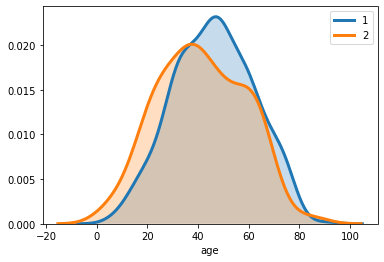

1
2


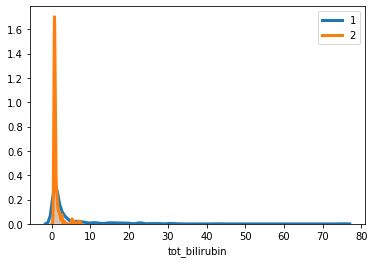

1
2


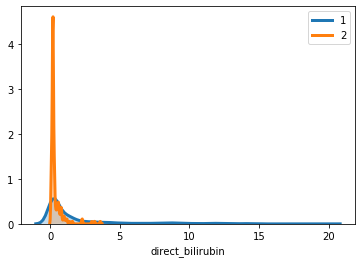

1
2


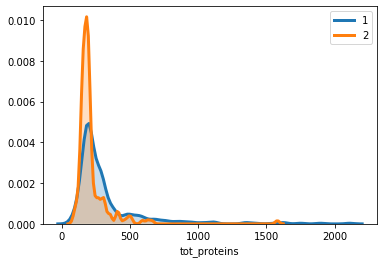

1
2


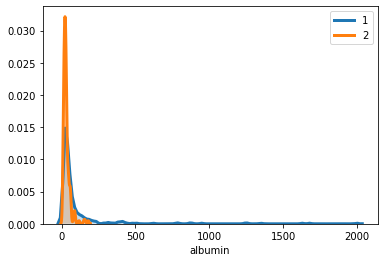

1
2


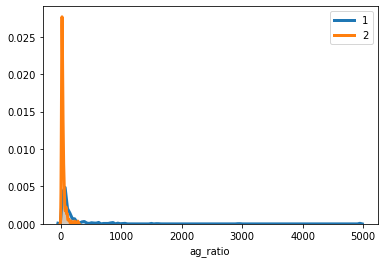

1
2


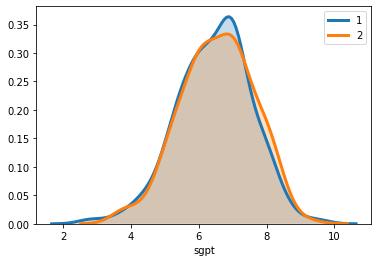

1
2


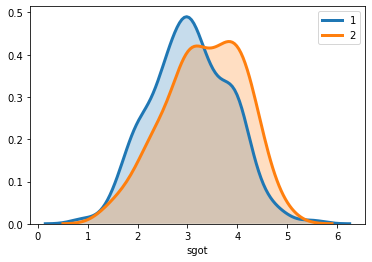

1
2


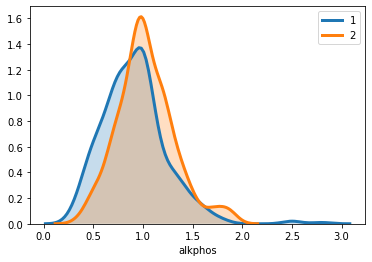

1
2


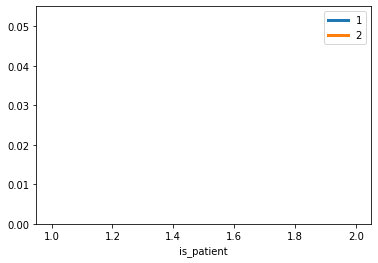

In [105]:
#df.loc[:, df["is_patient"] == 1]

var = "tot_proteins"
one = df.loc[df["is_patient"] == 1, [var]]
two = df.loc[df["is_patient"] == 2, [var]]

for var in df.columns:
    for label in df["is_patient"].unique():
        print(label)
        # Subset to the airline
        subset = df[df["is_patient"] == label]

        # Draw the density plot
        sns.distplot(subset[var], hist = False, kde = True,
                     kde_kws = {'shade': True,'linewidth': 3},
                     label = label)
    plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x1a27c5c7d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1a28ffd250>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a27c5c390>,
 'medians': [<matplotlib.lines.Line2D at 0x1a283ab810>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a283ab190>,
 'means': []}

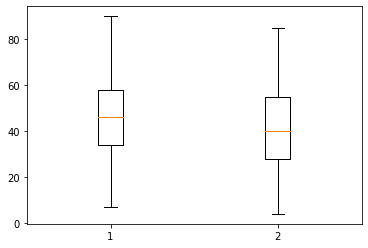

In [72]:
#plt.scatter(df.index, df["tot_bilirubin"], c = df["is_patient"])
plt.boxplot([one["age"], two["age"]])

/Users/mchifala/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/mchifala/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/mchifala/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/mchifala/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


<Figure size 720x720 with 0 Axes>

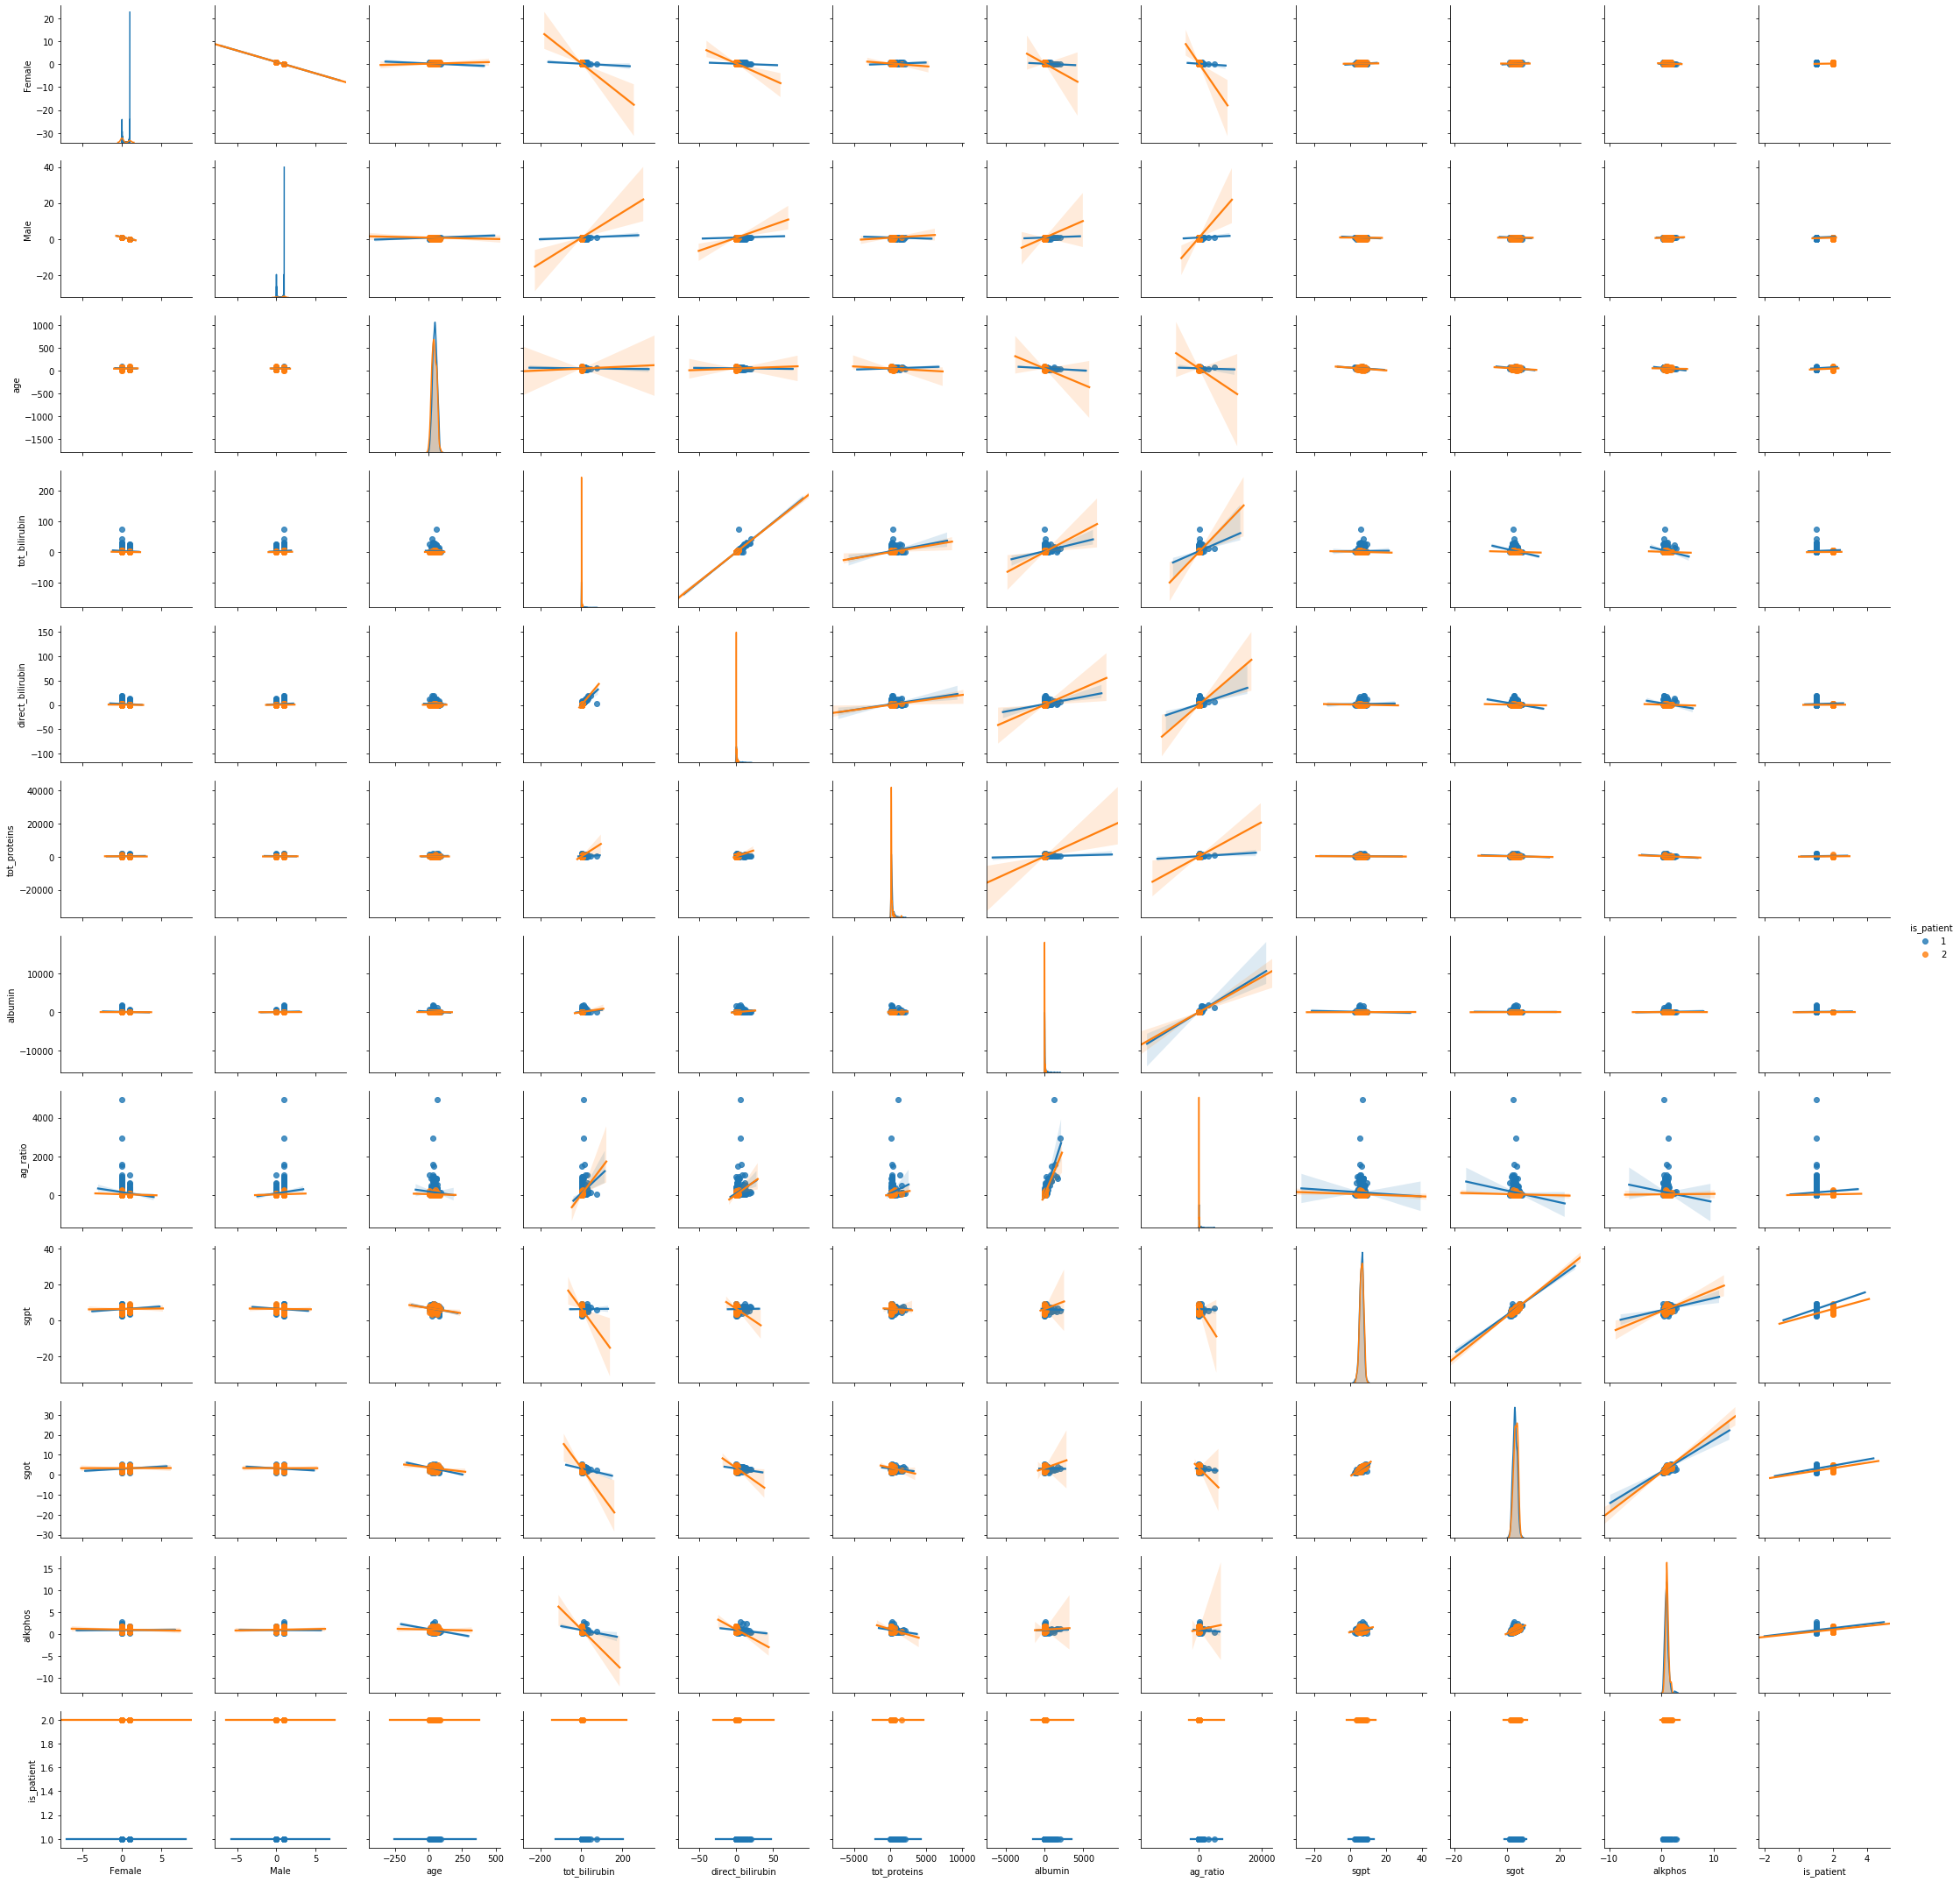

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize  = (10,10))
sns.pairplot(df, kind="reg", hue="is_patient")
plt.show()